In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline  # attention to imblearn Pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import time
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)

In [2]:
Data =  pd.read_csv('creditcard.csv')

In [3]:
Data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


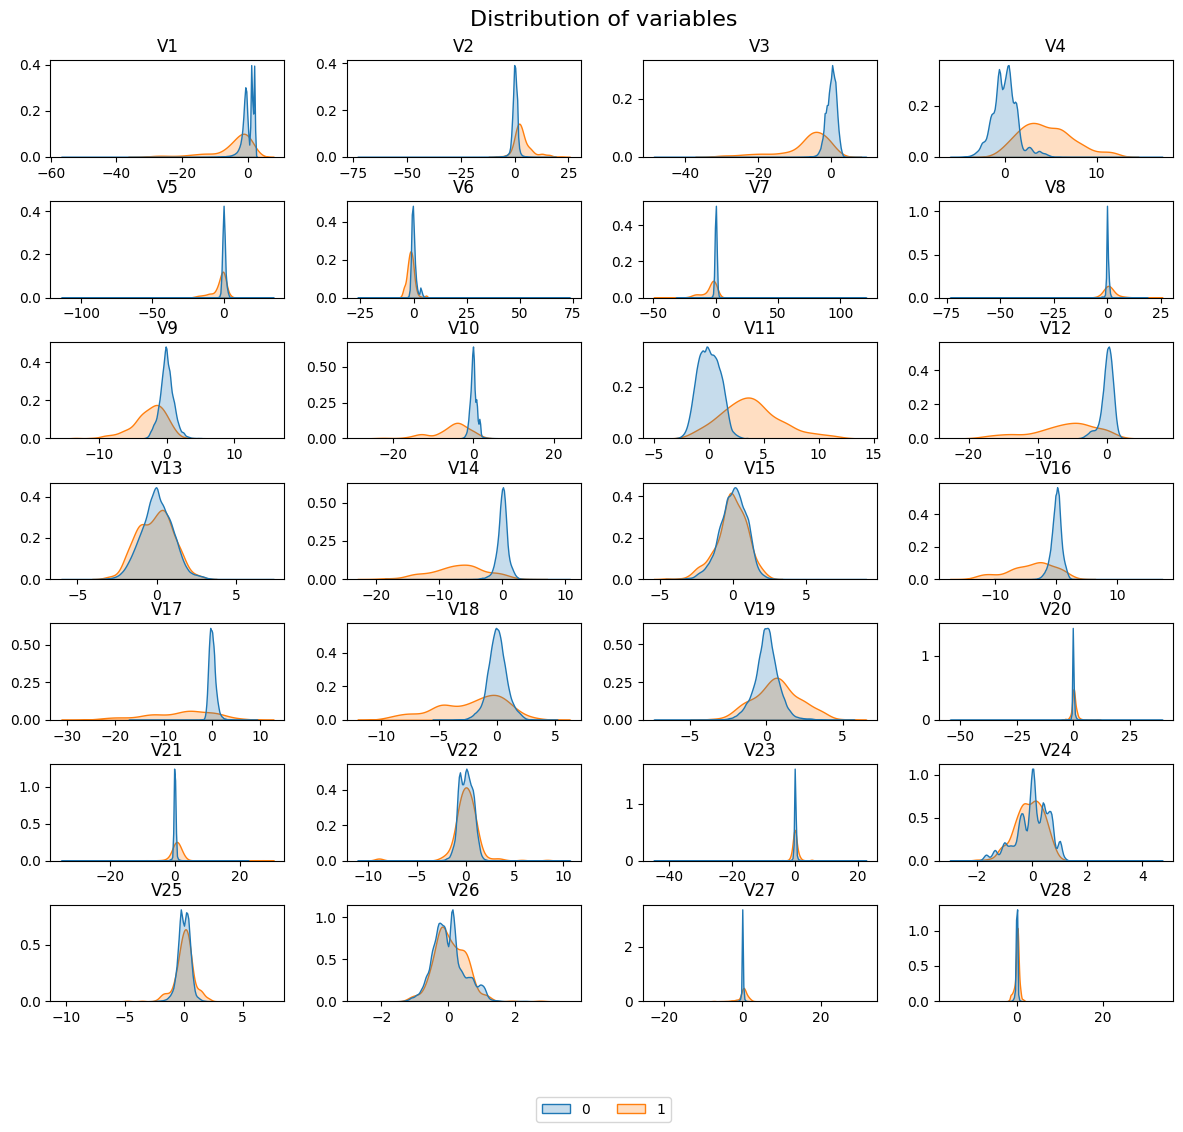

In [4]:
features_v = [col for col in Data.columns if col.startswith('V')]
fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(12, 10))
fig.tight_layout()
for ax, feature in zip(axs.flatten(), features_v):
    k = sns.kdeplot(x=feature, data=Data, ax=ax, hue='Class', fill=True, common_norm=False)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')
    legend = ax.get_legend()
    legend.remove()
labels = [text.get_text() for text in legend.get_texts()]

fig.legend(
    loc='upper center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.05),  # Adjust the vertical position as needed
    bbox_transform=fig.transFigure,
    handles=legend.legend_handles,
    labels=labels
)

fig.suptitle('Distribution of variables', fontsize=16, y=1.03)  # Adjust the y value as needed to move the title

plt.show()

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
Data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
from pandas_profiling import ydata_profiling, ProfileReport
profile = ProfileReport(Data, title="Data_analysis_Fraud_detection_01 ")
profile.to_file("summary.html")

C:\Users\vinic\AppData\Local\Temp\ipykernel_5776\2940993336.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ydata_profiling, ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
with pd.option_context('display.max_columns',40,
                      'display.precision',2,
                      'display.float_format',lambda numero: f'{numero:,.2f}'):
    display(Data.describe())



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00"
mean,"94,813.86",0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,"47,488.15",1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,"54,201.50",-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,"84,692.00",0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,"139,320.50",1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,"172,792.00",2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,"25,691.16",1.00


In [9]:
Data.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
def limits(columns):
    Q1 = columns.quantile(0.25) #quantile = quartil
    Q3 =  columns.quantile(0.75)
    amplitude = Q3- Q1
    inferior_limit = Q1 - 1.5 * amplitude
    superior_limit =  Q3 + 1.5 * amplitude
    return inferior_limit,superior_limit


def boxplot(coluna):
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna,ax=ax1)
    ax2.set_xlim(limits(coluna))
    sns.boxplot(x=coluna,ax=ax2)
    return



def delete_outliers(data,column_name):
    total_lines = data.shape[0]
    inferior_limits,superior_limits = limits(df[column_name])
    data = data.loc[(data[column_name]>= inferior_limits) & (data[column_name] <=superior_limits),:]
    removed_lines = total_lines -  data.shape[0]
    return data, removed_lines


def inspect_outliers(DataFrame, columns, whisker_width=1.5):
    Q1 = DataFrame[columns].quantile(0.25)
    Q3 = DataFrame[columns].quantile(0.75)
    iqr = Q3 - Q1
    inferior_limit = Q1 - whisker_width * iqr
    superior_limit = Q3 + whisker_width * iqr
    return DataFrame[
        (DataFrame[columns] < inferior_limit) | (DataFrame[columns] > superior_limit)
    ]
    

(-101.7475, 184.5125)


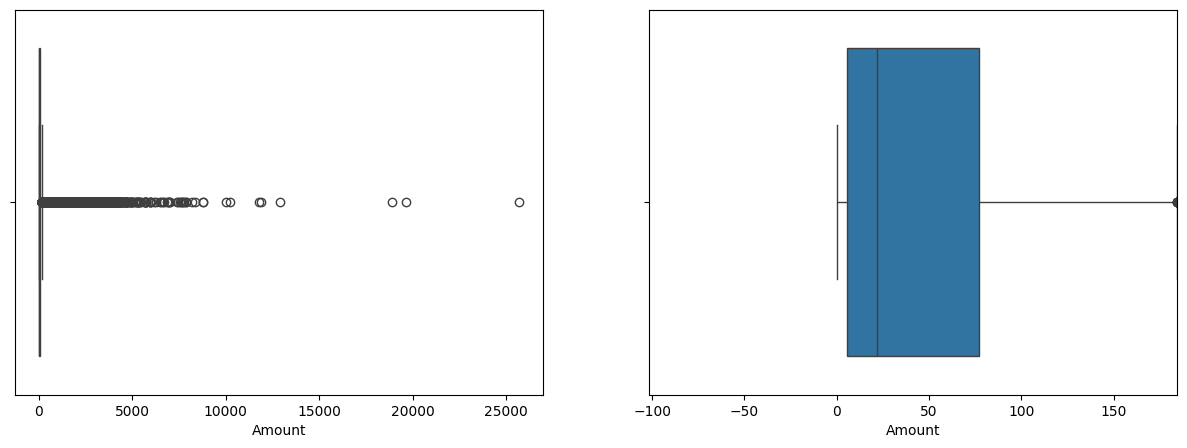

In [11]:
print(limits(Data.Amount))
boxplot(Data.Amount)

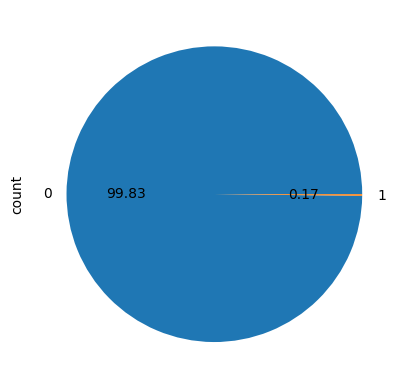

In [12]:
Data.Class.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [13]:
features_v = [col for col in Data.columns if col.startswith('V')]
inspect_outliers(Data,'V1')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
18,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,...,-0.503600,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0
85,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,...,-0.047365,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0
140,87.0,-5.101877,1.897022,-3.458034,-1.277543,-5.517758,2.098366,3.329603,1.250966,0.271501,...,-0.871744,-0.678879,-0.555900,-0.761660,0.066611,0.767227,0.731634,-0.860310,919.60,0
146,92.0,-5.285971,4.847323,-1.290368,-1.427842,-0.621533,-0.604691,0.437866,0.336384,3.558373,...,-0.923604,-1.171187,0.150872,-0.493322,1.050554,0.194865,2.490503,1.575380,8.95,0
164,103.0,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,...,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284631,172623.0,-5.459612,4.844512,-5.127471,-0.772816,-2.098147,0.010068,-2.943210,4.723736,0.030501,...,-0.104680,-0.823664,0.766333,-0.498784,0.022025,0.271928,-0.032666,-0.021239,9.82,0
284649,172642.0,-11.946976,9.772660,-8.006237,-2.498596,-4.229520,-1.320039,-3.259766,5.059956,4.870093,...,-0.957977,-1.529035,0.838689,-1.249172,1.714495,0.314623,2.112848,1.234408,10.74,0
284772,172760.0,-6.713826,2.369104,-3.534768,-0.368259,-1.721030,-1.322808,-0.190876,0.891149,2.068476,...,0.131247,0.994246,-0.002140,-0.072979,-0.167159,-0.387271,-2.616341,0.474584,19.59,0
284795,172778.0,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,9.87,0


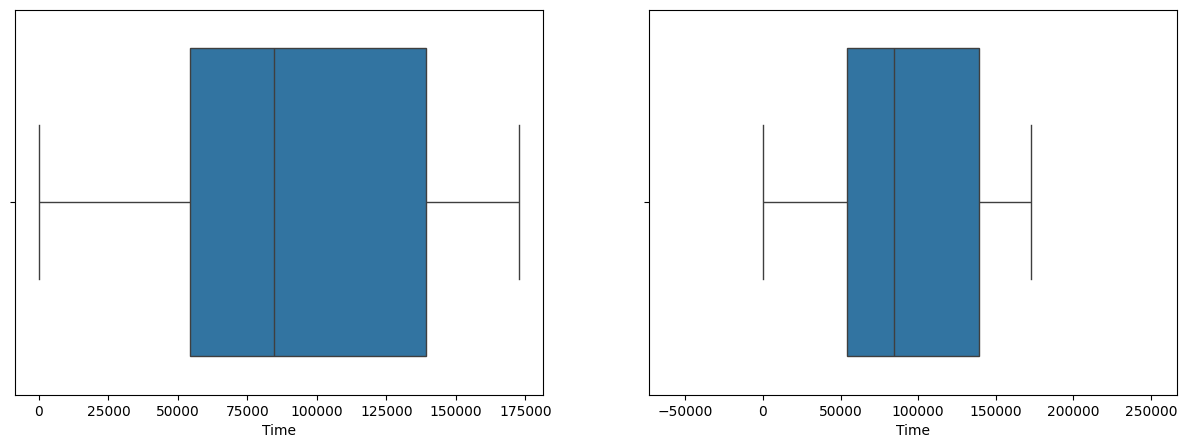

In [14]:
boxplot(Data['Time'])

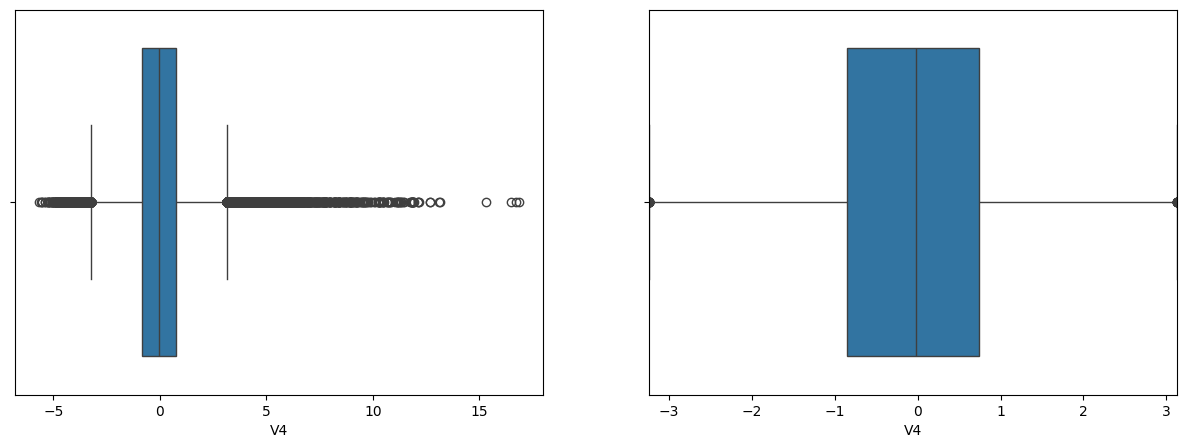

In [15]:
boxplot(Data['V4'])

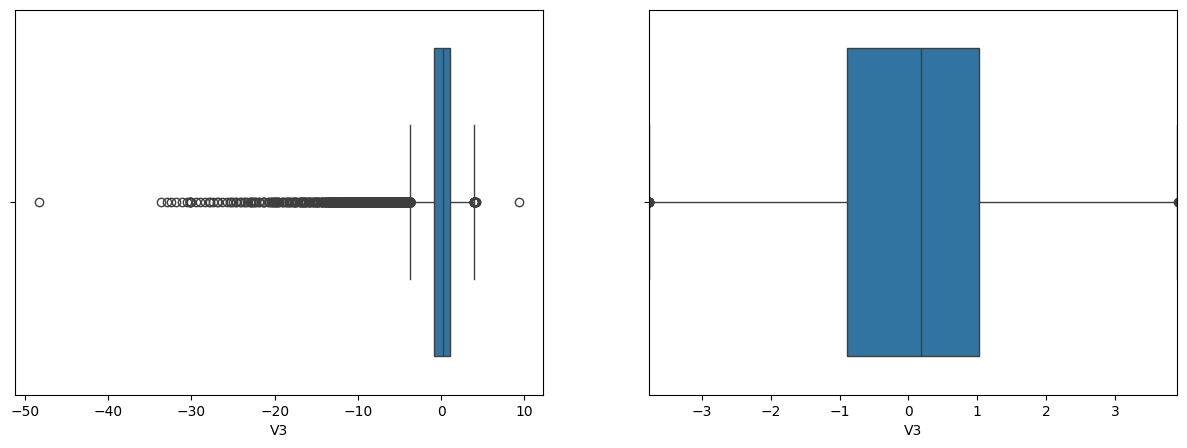

In [16]:
boxplot(Data['V3'])

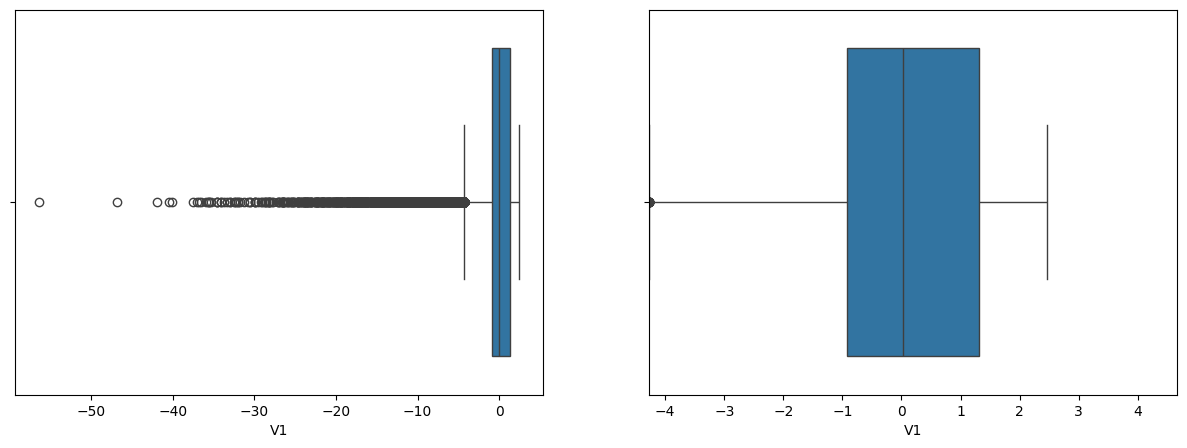

In [17]:
boxplot(Data['V1'])

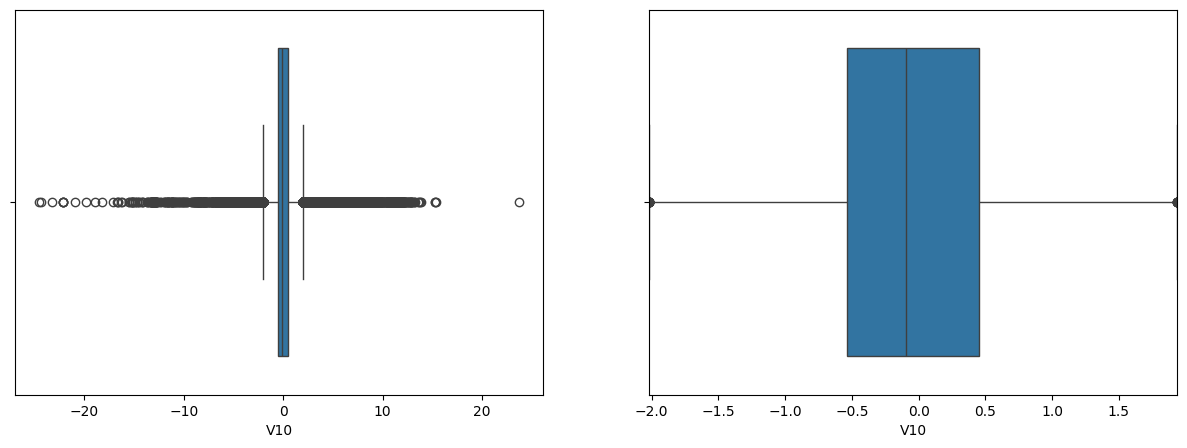

In [18]:
boxplot(Data['V10'])

# I am assuming that all Dataframe columns have outliers

In [19]:
# ou posso fazer um escalamento dos dados

In [20]:
print(type(Data.Amount))

<class 'pandas.core.series.Series'>


In [21]:
Rob_scaler = RobustScaler()
Data['scaled_amount'] = Rob_scaler.fit_transform(Data[['Amount']])
Data['scaled_time'] =  Rob_scaler.fit_transform(Data[['Time']])

In [22]:
Data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579,-0.994960


In [23]:
Data_scaled = Data.copy()

In [24]:
Data_scaled = Data.drop(['Amount','Time'],axis=1)

In [25]:
Data_scaled.to_csv('Data_scaled.csv',index=False)

In [26]:
Data_scaled.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983


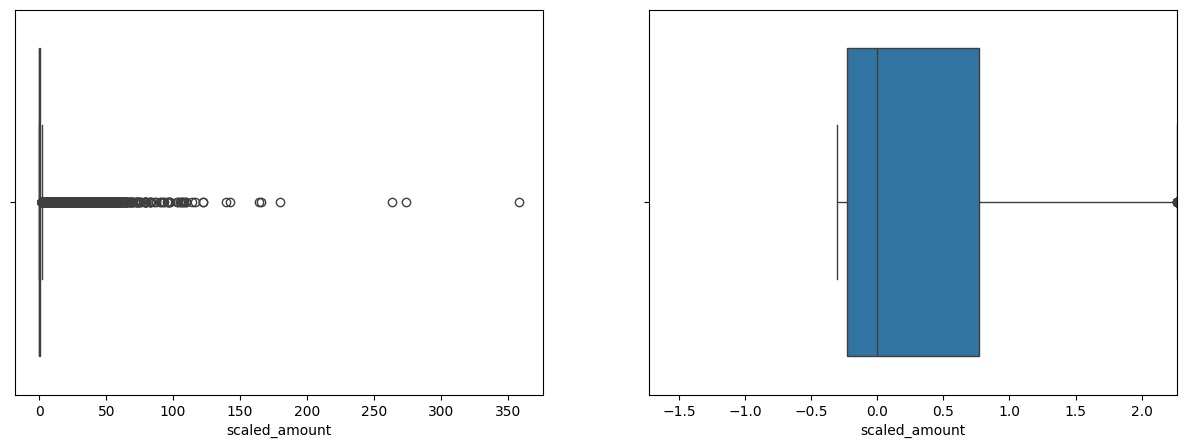

In [27]:
boxplot(Data['scaled_amount'])

# If it is not good for the model I will remove the outliers from all lines

In [28]:
X = Data_scaled.drop('Class',axis=1)
y = Data_scaled.Class

In [29]:
RANDOM_STATE = 42

X_train , X_test , y_train , y_test = train_test_split(
    X,y,test_size=0.33,random_state=RANDOM_STATE,stratify=y
)

In [30]:
X_train.shape[0]

190820

In [31]:
y_train.shape[0]

190820

In [32]:
samplers = {
    "RUS": RandomUnderSampler(random_state=RANDOM_STATE),
    "ROS": RandomOverSampler(random_state=RANDOM_STATE),
}

In [33]:
def resampling(X,y,sampler,model,kf):
      # ColumnTransformer
    preprocessing = ColumnTransformer(
        transformers=[
            ("rob_scaler", RobustScaler(), ["scaled_time", "scaled_amount"]),
        ],
        remainder="passthrough"
    )
    pipeline = Pipeline(
    [
        ('preprossesing',preprocessing),
        ('sampler',sampler),
        ('model',model),
        
    ]
)
    
    param_grid = {
        'sampler__sampling_strategy':['auto',0.5,0.75,1],
        'model__C':np.logspace(-3,3,7),
        'model__penalty':['11','12','elasticnet',None],
        'model__solver':['lbfgs','saga']
    }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring=['recall','average_precision'],
        refit='average_precision',
        cv=kf,
        #n_jobs=  if you dont have a good machine
        verbose=1
    )
    
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-1,
    )
 
    return scores

In [34]:
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [35]:
resultados_rus = {
    "DecisionTreeClassifier": resampling(
        X, y, samplers["RUS"], models["DecisionTreeClassifier"], skf
    ),
    "LogisticRegression": resampling(
        X, y, samplers["RUS"], models["LogisticRegression"], skf
    ),
    "KNNClassifier": resampling(X, y, samplers["RUS"], models["KNNClassifier"], skf),
}

In [36]:
resultados_ros = {
    "DecisionTreeClassifier": resampling(
        X, y, samplers["ROS"], models["DecisionTreeClassifier"], skf
    ),
    "LogisticRegression": resampling(
        X, y, samplers["ROS"], models["LogisticRegression"], skf
    ),
    "KNNClassifier": resampling(X, y, samplers["ROS"], models["KNNClassifier"], skf),
} #extremely slow algorithm! It would not be a viable option!

In [37]:
# criando uma chave time para cada modelo em cada dicionário, que é a soma de fit_time e score_time

for k ,v in resultados_rus.items():
    print(k)
    resultados_rus[k]['time'] = resultados_rus[k]['fit_time'] +resultados_rus[k][
        "score_time"
    ]
for k , v in resultados_ros.items():
    resultados_ros[k]['time'] = resultados_ros[k]['fit_time'] +resultados_ros[k][
        "score_time"
    ]
    
    


DecisionTreeClassifier
LogisticRegression
KNNClassifier


In [38]:
df_rus = pd.DataFrame(resultados_rus).T.assign(sampler="RUS").reset_index().rename(
    columns={"index": "modelo"}
)
df_ros = pd.DataFrame(resultados_ros).T.assign(sampler="ROS").reset_index().rename(
    columns={"index": "modelo"}
)


In [39]:
df_resultados = pd.concat([df_rus, df_ros]).reset_index(drop=True)

In [40]:
df_resultados.head()

,modelo,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,sampler
0,DecisionTreeClassifier,"[0.40236353874206543, 0.3026416301727295, 0.42...","[0.13571548461914062, 0.14858508110046387, 0.1...","[0.9138021839120818, 0.8965801762578561, 0.908...","[0.017839246341952296, 0.015557042489126798, 0...","[0.898989898989899, 0.9393939393939394, 0.8979...","[0.9064089357425974, 0.9179497878739916, 0.903...","[0.016212857900587904, 0.014719524809327889, 0...","[0.538079023361206, 0.45122671127319336, 0.554...",RUS
1,LogisticRegression,"[0.14976811408996582, 0.2506122589111328, 0.24...","[0.08246731758117676, 0.10926985740661621, 0.1...","[0.9673642077174257, 0.9696639865173273, 0.975...","[0.04639175257731959, 0.0512396694214876, 0.06...","[0.9090909090909091, 0.9393939393939394, 0.928...","[0.9840039066073571, 0.9798439879511931, 0.981...","[0.7157336581702124, 0.7519999839227538, 0.742...","[0.23223543167114258, 0.359882116317749, 0.358...",RUS
2,KNNClassifier,"[0.2548689842224121, 0.25995898246765137, 0.26...","[2.0504915714263916, 1.9983577728271484, 2.124...","[0.9711562094027597, 0.9706997647554511, 0.977...","[0.05168408826945412, 0.05142857142857143, 0.0...","[0.898989898989899, 0.9090909090909091, 0.8775...","[0.9728162869572925, 0.9736679707047081, 0.980...","[0.4555921737524092, 0.4204599930489723, 0.400...","[2.3053605556488037, 2.2583167552948, 2.391541...",RUS
3,DecisionTreeClassifier,"[15.876964569091797, 15.573976755142212, 18.93...","[0.08843111991882324, 0.146592378616333, 0.080...","[0.9992802219023208, 0.9993153330290369, 0.999...","[0.8222222222222222, 0.8333333333333334, 0.745...","[0.7474747474747475, 0.7575757575757576, 0.775...","[0.8735966847128762, 0.8786559828274124, 0.887...","[0.615029237007632, 0.6317344648337241, 0.5782...","[15.96539568901062, 15.720569133758545, 19.013...",ROS
4,LogisticRegression,"[4.477494716644287, 4.782697916030884, 4.70320...","[0.11522388458251953, 0.09388375282287598, 0.0...","[0.9793019908008848, 0.9760893227063656, 0.975...","[0.07074721780604133, 0.06418219461697723, 0.0...","[0.898989898989899, 0.9393939393939394, 0.9285...","[0.9877607654193483, 0.9832585389977719, 0.980...","[0.7153709391839109, 0.7320163716484203, 0.748...","[4.592718601226807, 4.87658166885376, 4.800625...",ROS


In [41]:
list_columns = df_resultados.columns[1:-1].tolist()

In [42]:
df_resultados = df_resultados.explode(list_columns)

In [43]:
df_results_explode = df_resultados.explode(list_columns).reset_index(drop=True)

In [44]:
df_results_explode.head()

,modelo,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time,sampler
0,DecisionTreeClassifier,0.402364,0.135715,0.913802,0.017839,0.89899,0.906409,0.016213,0.538079,RUS
1,DecisionTreeClassifier,0.302642,0.148585,0.89658,0.015557,0.939394,0.91795,0.01472,0.451227,RUS
2,DecisionTreeClassifier,0.425299,0.128737,0.90806,0.016557,0.897959,0.903018,0.015043,0.554036,RUS
3,DecisionTreeClassifier,0.395381,0.131652,0.906515,0.016287,0.897959,0.902244,0.014801,0.527034,RUS
4,DecisionTreeClassifier,0.434323,0.104805,0.889661,0.01383,0.897959,0.893803,0.012594,0.539128,RUS


In [45]:
df_results_explode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   modelo                  30 non-null     object
 1   fit_time                30 non-null     object
 2   score_time              30 non-null     object
 3   test_accuracy           30 non-null     object
 4   test_precision          30 non-null     object
 5   test_recall             30 non-null     object
 6   test_roc_auc            30 non-null     object
 7   test_average_precision  30 non-null     object
 8   time                    30 non-null     object
 9   sampler                 30 non-null     object
dtypes: object(10)
memory usage: 2.5+ KB


In [46]:
df_results_explode = df_results_explode.apply(pd.to_numeric,errors='ignore')

C:\Users\vinic\AppData\Local\Temp\ipykernel_5776\2658370007.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_results_explode = df_results_explode.apply(pd.to_numeric,errors='ignore')


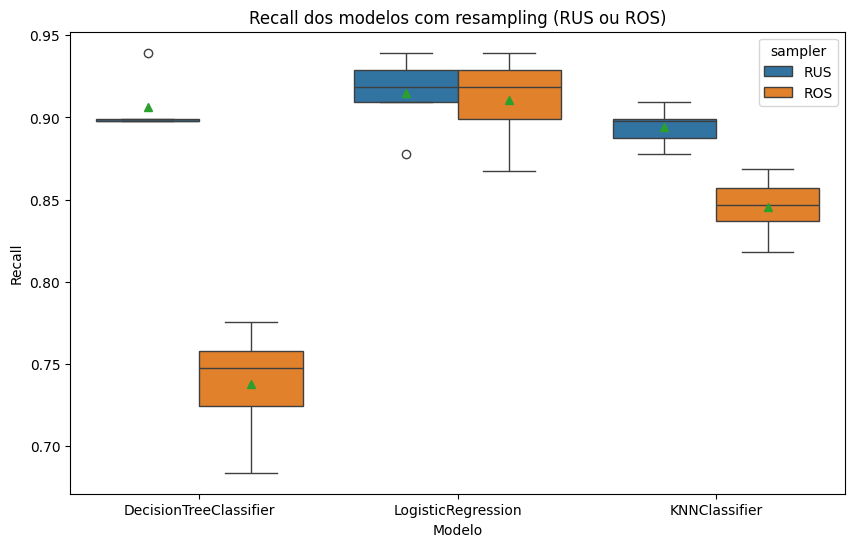

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(
    x="modelo",
    y="test_recall",
    hue="sampler",
    data=df_results_explode,
    ax=ax,
    showmeans=True,
)

ax.set_title("Recall dos modelos com resampling (RUS ou ROS)")
ax.set_xlabel("Modelo")
ax.set_ylabel("Recall")

plt.show()

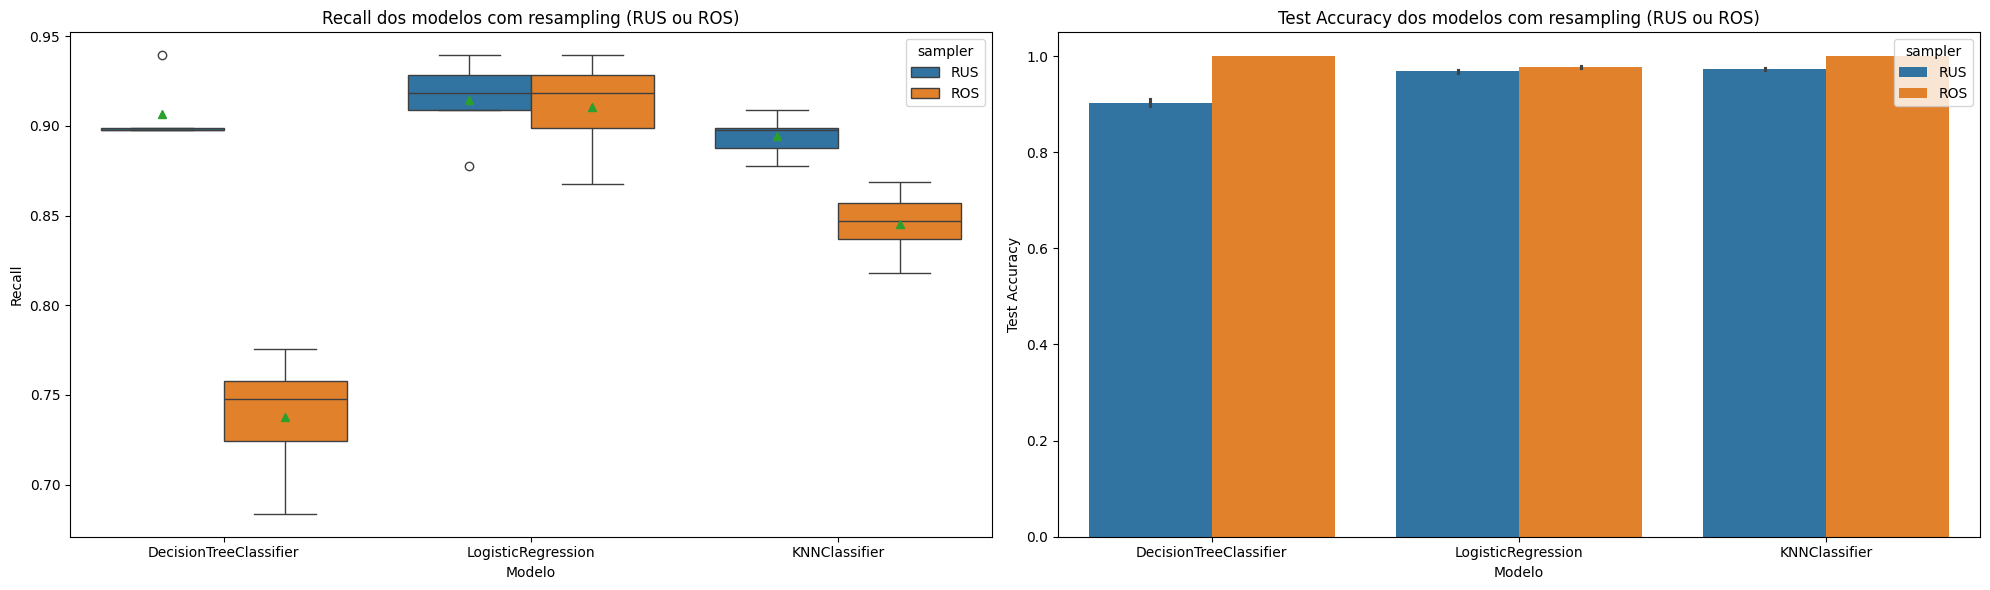

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(
    x="modelo",
    y="test_recall",
    hue="sampler",
    data=df_results_explode,
    ax=axes[0],
    showmeans=True,
)
axes[0].set_title("Recall dos modelos com resampling (RUS ou ROS)")
axes[0].set_xlabel("Modelo")
axes[0].set_ylabel("Recall")
sns.barplot(
    x="modelo",
    y="test_accuracy",
    hue="sampler",
    data=df_results_explode,
    ax=axes[1],
)
axes[1].set_title("Test Accuracy dos modelos com resampling (RUS ou ROS)")
axes[1].set_xlabel("Modelo")
axes[1].set_ylabel("Test Accuracy")
plt.tight_layout()
plt.show()


In [49]:
columns_scoring = ['test_precision','test_accuracy','test_roc_auc','test_average_precision'
                  'time'
                  ]

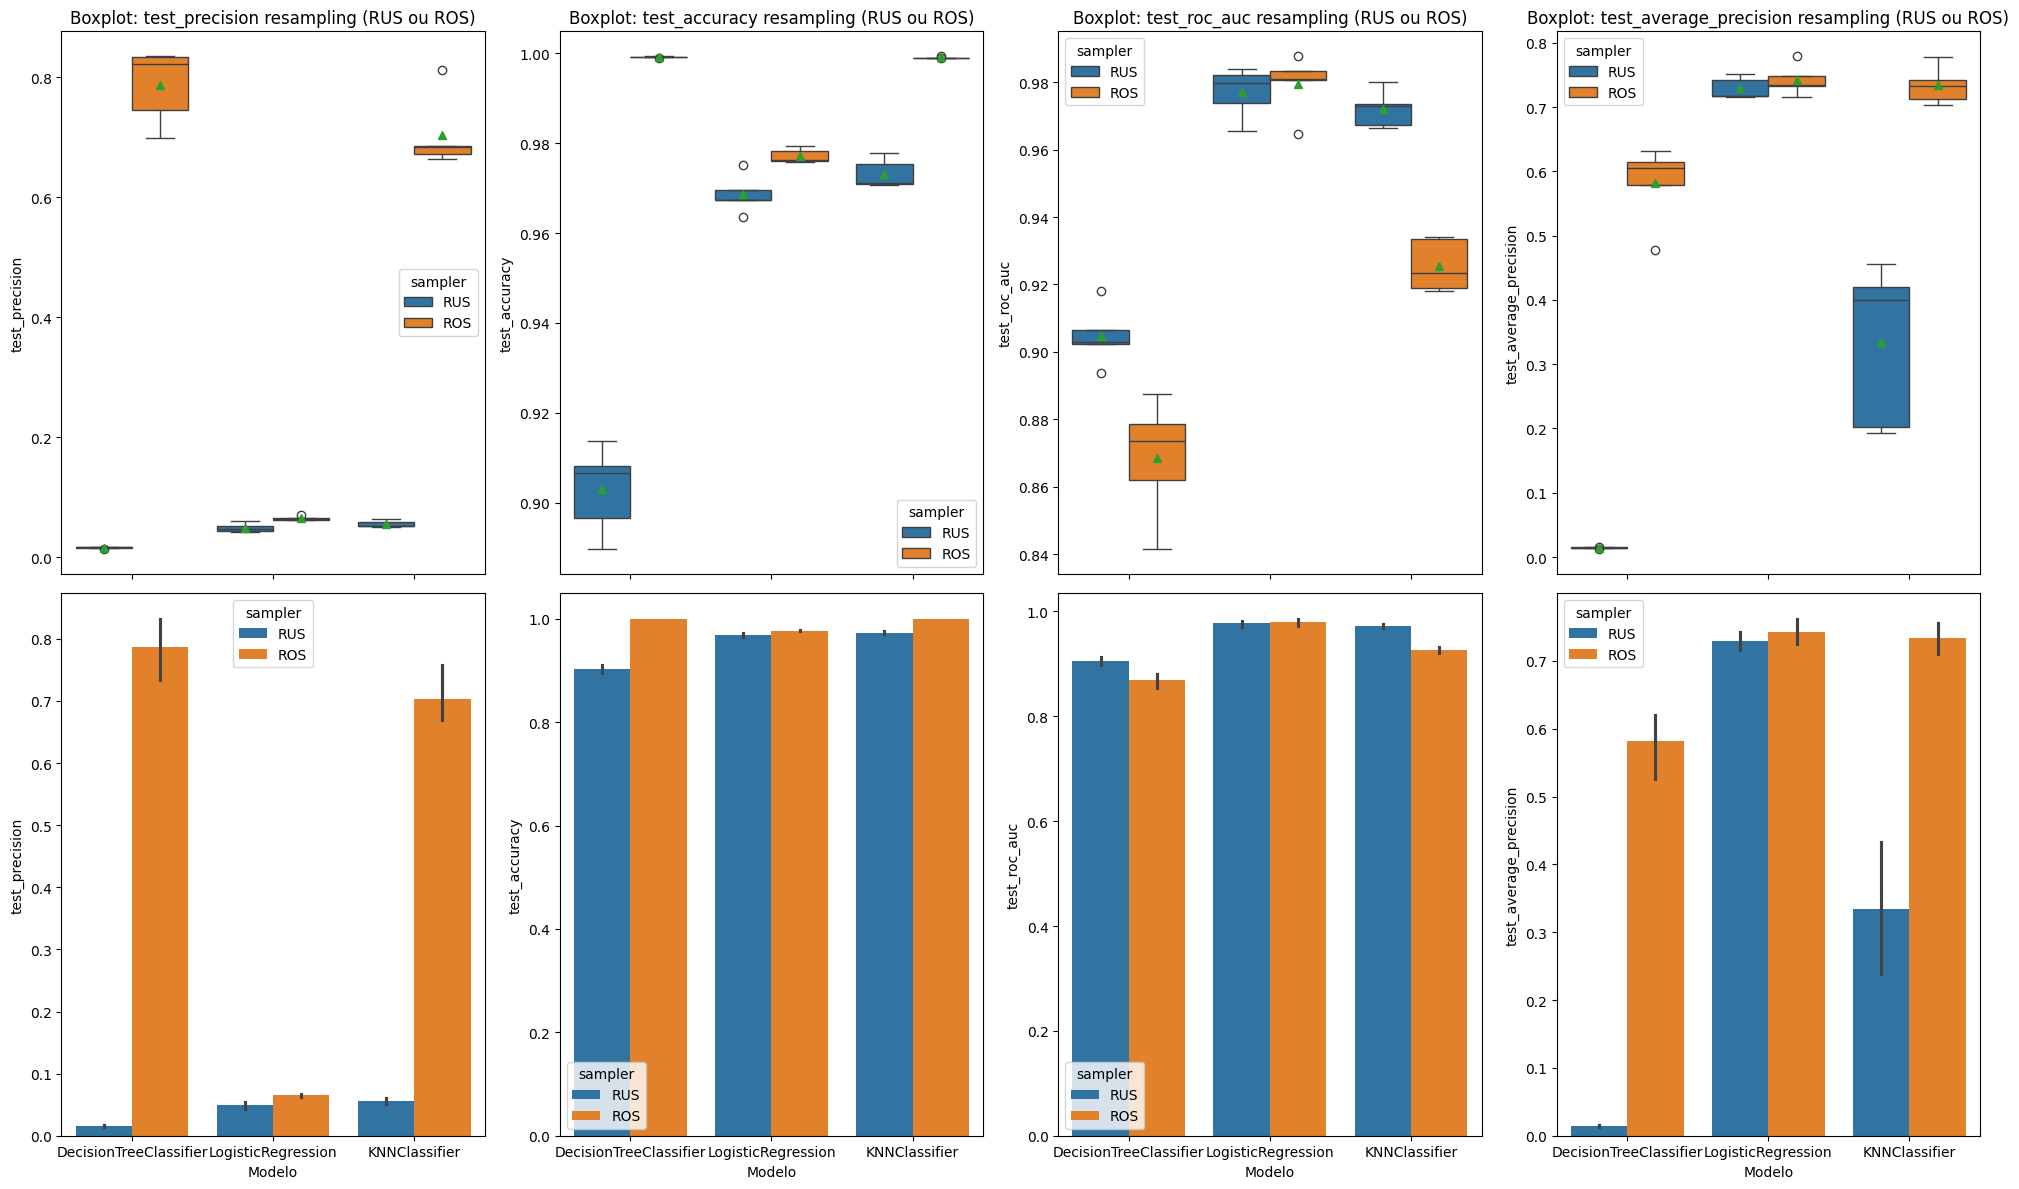

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_scoring = [
    'test_precision', 'test_accuracy', 'test_roc_auc', 'test_average_precision'
]

fig, axes = plt.subplots(2, len(columns_scoring), figsize=(5 * len(columns_scoring), 12),sharex=True)

for idx, metric in enumerate(columns_scoring):
    
    sns.boxplot(
        x="modelo",
        y=metric,
        hue="sampler",
        data=df_results_explode,
        ax=axes[0, idx],
        showmeans=True,
    )
    axes[0, idx].set_title(f"Boxplot: {metric} resampling (RUS ou ROS)")
    axes[0, idx].set_xlabel("Modelo")
    axes[0, idx].set_ylabel(metric)

    
    sns.barplot(
        x="modelo",
        y=metric,
        hue="sampler",
        data=df_results_explode,
        ax=axes[1, idx],
    )
    axes[1, idx].set_xlabel("Modelo")
    axes[1, idx].set_ylabel(metric)
    
plt.tight_layout()
plt.show()


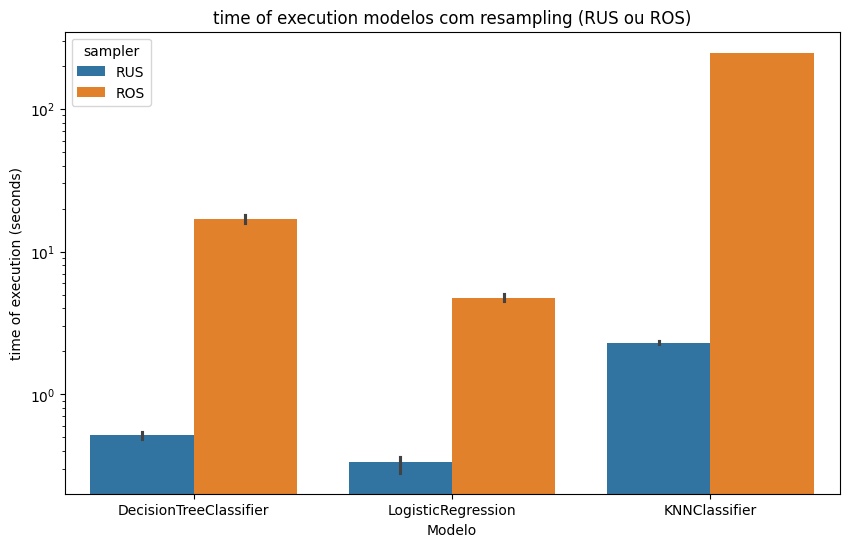

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x="modelo",
    y="time",
    hue="sampler",
    data=df_results_explode,
    ax=ax,
)

ax.set_title("time of execution modelos com resampling (RUS ou ROS)")
ax.set_xlabel("Modelo")
ax.set_ylabel("time of execution (seconds)")
ax.set_yscale('log')
plt.show()

In [52]:
rus =samplers['RUS']
X_res ,y_res = rus.fit_resample(X_train,y_train)


clfRU = LogisticRegression(random_state=42)
clfRU = clfRU.fit(X_res,y_res)

y_predRU = clfRU.predict(X_test)

confusion_matrix(y_test,y_predRU)

array([[90090,  3735],
       [   15,   147]], dtype=int64)

In [53]:
ros =samplers['ROS']
X_res ,y_res = ros.fit_resample(X_train,y_train)


clfRO = LogisticRegression(random_state=42)
clfRO = clfRO.fit(X_res,y_res)

y_predRO = clfRO.predict(X_test)

confusion_matrix(y_test,y_predRO)

array([[91804,  2021],
       [   18,   144]], dtype=int64)

In [54]:
accuracy_score(y_test,y_predRU) #Random Under Sampler

0.9601008650132465

In [55]:
accuracy_score(y_test,y_predRO) #Random Over Sampler

0.9783055103365359

# Be Careful!!!!

# When working with an unbalanced dataset for fraud identification, where 0 represents "not fraud" and 1 represents "it is fraud", it is common to find a highly disproportionate distribution between classes. In the case presented, 99% of the data corresponds to "it is not fraud", while only 1% corresponds to "it is fraud". When training a logistic regression model for this classification task, the reported accuracy was 99%. While this may seem excellent at first glance, this metric does not reflect the true performance of the model. The high accuracy observed is due to the fact that the model classified almost all instances as "not fraud", due to the predominance of this class in the dataset. In other words, the model is simply predicting the majority class while ignoring the minority class (cheats), which results in a false sense of effectiveness. Therefore, in situations of extreme imbalance, accuracy is not an appropriate metric to evaluate model performance. More appropriate metrics include precision, recall, and F1-score, which offer more detailed insight into the model's performance in detecting minority classes. Using these metrics can help ensure that the model has a real ability to identify fraud, rather than simply favoring the majority class.




In [56]:
from sklearn.metrics import f1_score  # Random Under Sampler
f1_score(y_test, y_predRU)

0.07270029673590504

In [57]:
from sklearn.metrics import f1_score  # Random Over Sampler
f1_score(y_test, y_predRO)

0.1237645036527718

# The F1 Score is an evaluation metric that combines precision and recall into a single value. It is especially useful in situations with unbalanced classes, such as fraud detection. Below, explain how to calculate and interpret the F1 Score, as well as its meaning.


# Calculation of F1 Score
# First, let's understand the concepts of precision and recall:

# Precision: It is the proportion of true positives (TP) among all positive predictions (TP + FP). Indicates how many of the instances classified as positive are actually positive.

# Recall: It is the proportion of true positives (TP) among all instances that are truly positive (TP + FN). Indicates how many of the positive instances were correctly identified.

# Interpretation of F1 Score
# Value between 0 and 1: The F1 Score ranges from 0 to 1, where 1 indicates the best possible performance (perfect precision and recall) and 0 indicates the worst possible performance.
# Balance between Precision and Recall: A high F1 Score indicates that both precision and recall are high, meaning that the model has a good ability to identify positive instances (fraud) without generating many false positives.
# Usability in Unbalanced Datasets: In unbalanced datasets, where the positive class is much less frequent than the negative class, the F1 Score is a more informative metric than accuracy, as it takes into account both false positives and false negatives.

In [58]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate
from imblearn.pipeline import Pipeline #PipeLine do Imlearn for Imbalanced Datasets!
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
preprocessing = ColumnTransformer(
        transformers=[
            ("rob_scaler", RobustScaler(), ["scaled_time", "scaled_amount"]),
        ],
        remainder="passthrough"
    )

pipeline_log_reg = Pipeline(
    [
        ('preprossesing',preprocessing),
        ('feature_selection',SelectKBest(score_func=f_classif,k=10)),  #pegar as melhores features em modelo de classificacao
        ('RUS',RandomUnderSampler(random_state=42)),
        ('Model',LogisticRegression(random_state=RANDOM_STATE)),
    ]

)

In [59]:
display(pipeline_log_reg.fit(X,y))

C:\Users\vinic\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprossesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('rob_scaler', RobustScaler(),
                                                  ['scaled_time',
                                                   'scaled_amount'])])),
                ('feature_selection', SelectKBest()),
                ('RUS', RandomUnderSampler(random_state=42)),
                ('Model', LogisticRegression(random_state=42))])

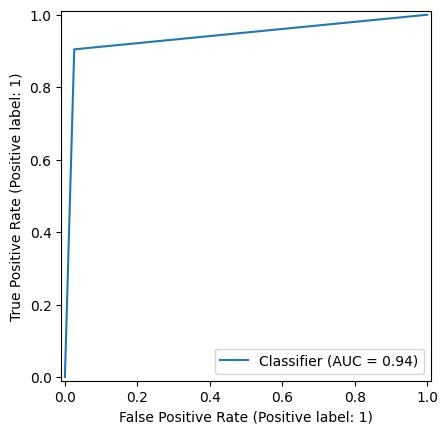

In [60]:
# ROC CURVE
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(pipeline_log_reg,X,y,cv=skf,n_jobs=-1)
roc = RocCurveDisplay.from_predictions(y,y_pred)
plt.show()

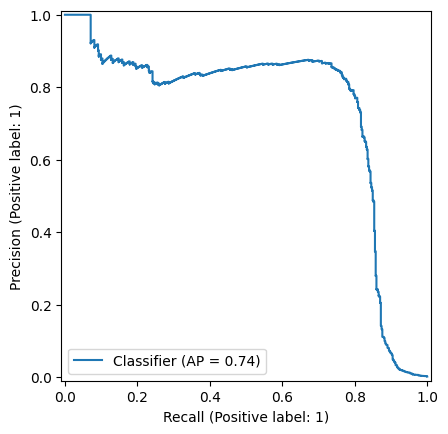

In [61]:
# PRecision CURVE
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import  PrecisionRecallDisplay

y_pred = cross_val_predict(pipeline_log_reg,X,y,cv=skf,n_jobs=-1,method='decision_function')
prc = PrecisionRecallDisplay.from_predictions(y,y_pred)
plt.show()

In [62]:
param_grid = {
        'feature_selection__k':['auto',10,15.20,25],
        'Model__C':np.logspace(-3,3,7),  #geralmente se usa valores muito pequenos ate valores muito grandes.por isso a tuilizade do logspace do numpy
        'Model__solver':['lbfgs','saga','liblinear'], #libliner e  bom para datasets pequenos,  #saga para datasets maiores  #lbfgs Default
        'Model__penalty':['l1','l2','elasticnet','none'],
    }

grid_search = GridSearchCV(
    pipeline_log_reg,
    param_grid,
    scoring=['roc_auc','average_precision','accuracy'],
    n_jobs=-1, # change this number if you dont have a good machine!
    refit='average_precision'
    

)

warnings.filterwarnings('ignore')  # Some warnings appeared because some combinations are not possible. If you want to see the warnings, comment out this line of code.
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprossesing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('rob_scaler',
                                                                         RobustScaler(),
                                                                         ['scaled_time',
                                                                          'scaled_amount'])])),
                                       ('feature_selection', SelectKBest()),
                                       ('RUS',
                                        RandomUnderSampler(random_state=42)),
                                       ('Model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'Model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'Model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'Model__solver': ['lbfgs', 'saga', 'liblinear'],
                         'feature_selection__k': ['auto', 10, 15.2, 25]},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

In [63]:
grid_search.best_params_

{'Model__C': 1000.0,
 'Model__penalty': 'l2',
 'Model__solver': 'lbfgs',
 'feature_selection__k': 10}

In [64]:
grid_search.best_score_

0.7677221322391835

In [65]:
df_results_Grid_seach = pd.DataFrame(
 {
     'auprc':grid_search.cv_results_['mean_test_average_precision'],
     'auroc':grid_search.cv_results_['mean_test_roc_auc'],
     'acurracy':grid_search.cv_results_['mean_test_accuracy'],
 }
)

In [66]:
df_results_Grid_seach

,auprc,auroc,acurracy
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
331,NaN,NaN,NaN
332,NaN,NaN,NaN
333,NaN,NaN,NaN
334,NaN,NaN,NaN


In [67]:
df_results_Grid_seach.describe()

,auprc,auroc,acurracy
count,70.000000,70.000000,70.000000
mean,0.654122,0.969783,0.949166
std,0.098507,0.012395,0.074758
min,0.457650,0.942529,0.548339
25%,0.572403,0.962346,0.949171
50%,0.700594,0.976364,0.967283
75%,0.730449,0.977632,0.971339
max,0.767722,0.978964,0.998606


In [68]:
columns = df_results_Grid_seach.columns

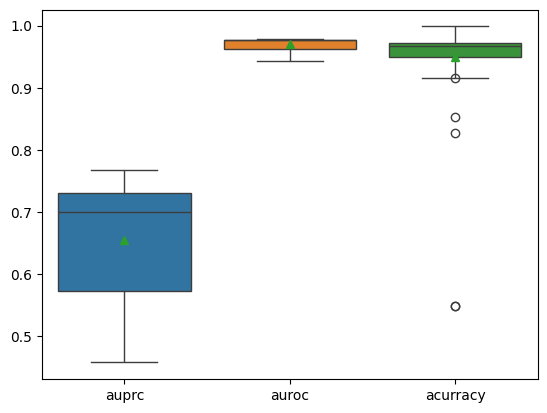

In [69]:
sns.boxplot(data=df_results_Grid_seach,showmeans=True)
plt.show()

In [70]:
pipeline_log_reg_GS_best = Pipeline(
    [
        ('preprossesing',preprocessing),
        ('feature_selection',SelectKBest(score_func=f_classif,k=10)),  #pegar as melhores features em modelo de classificacao
        ('RUS',RandomUnderSampler(random_state=42)),
        ('Model',LogisticRegression(
            random_state=RANDOM_STATE,
            C=grid_search.best_params_['Model__C'],
            penalty=grid_search.best_params_['Model__penalty'],
            solver=grid_search.best_params_['Model__solver'],
        )),
        
    ]

)

scores = cross_validate(
    pipeline_log_reg_GS_best,
    X,
    y,
    cv=skf,
    scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
    n_jobs=-1 # change this if you would like!
)

In [71]:
scores

{'fit_time': array([0.46391582, 0.48187137, 0.47591019, 0.47391152, 0.47262883]),
 'score_time': array([0.12875438, 0.13236475, 0.13535523, 0.14233518, 0.13136601]),
 'test_accuracy': array([0.97377199, 0.97340332, 0.97500044, 0.96555538, 0.97406998]),
 'test_precision': array([0.05601528, 0.0575    , 0.05976096, 0.04358472, 0.0554481 ]),
 'test_recall': array([0.88888889, 0.92929293, 0.91836735, 0.90816327, 0.87755102]),
 'test_roc_auc': array([0.98011204, 0.97651968, 0.98205174, 0.97410658, 0.97561827]),
 'test_average_precision': array([0.70908914, 0.76074886, 0.75976436, 0.76919112, 0.74549466])}

In [72]:
df_scores_best = pd.DataFrame(scores)

In [73]:
scores['Time'] =  scores['fit_time'] + scores['score_time']

In [74]:
pipeline_log_reg_GS_best

Pipeline(steps=[('preprossesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('rob_scaler', RobustScaler(),
                                                  ['scaled_time',
                                                   'scaled_amount'])])),
                ('feature_selection', SelectKBest()),
                ('RUS', RandomUnderSampler(random_state=42)),
                ('Model', LogisticRegression(C=1000.0, random_state=42))])

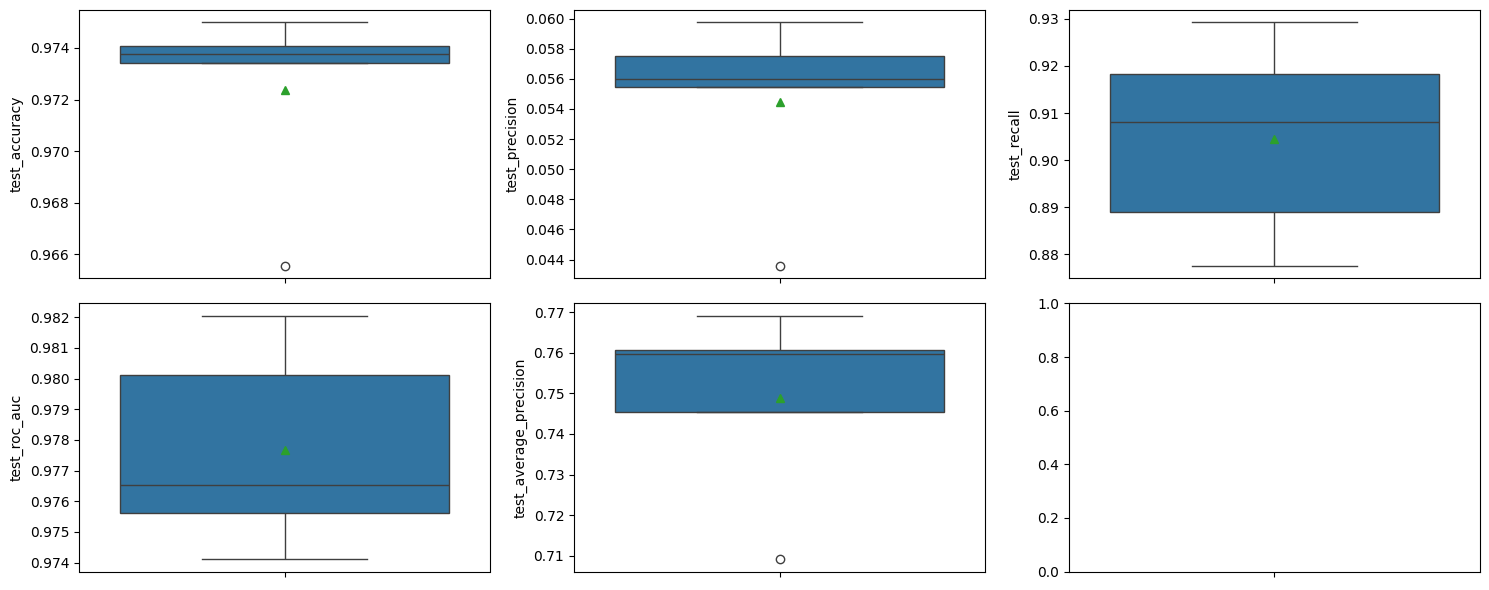

In [75]:
import matplotlib.patches as mpatches
fig ,axs = plt.subplots(ncols=3,nrows=2,figsize=(15,6),tight_layout=True,sharex=True)
cols = df_scores_best.columns[2:].tolist()
for ax ,col in zip(axs.flatten(),cols):
    box = sns.boxplot(y=col,data=df_scores_best, ax=ax,showmeans=True)

plt.show()

In [76]:
pipeline_log_reg_GS_best.fit(X,y)

Pipeline(steps=[('preprossesing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('rob_scaler', RobustScaler(),
                                                  ['scaled_time',
                                                   'scaled_amount'])])),
                ('feature_selection', SelectKBest()),
                ('RUS', RandomUnderSampler(random_state=42)),
                ('Model', LogisticRegression(C=1000.0, random_state=42))])

In [77]:
pipeline_log_reg_GS_best[:-2].get_feature_names_out()

array(['remainder__V3', 'remainder__V4', 'remainder__V7',
       'remainder__V10', 'remainder__V11', 'remainder__V12',
       'remainder__V14', 'remainder__V16', 'remainder__V17',
       'remainder__V18'], dtype=object)

In [78]:
pipeline_log_reg_GS_best[:-2].get_feature_names_out()

array(['remainder__V3', 'remainder__V4', 'remainder__V7',
       'remainder__V10', 'remainder__V11', 'remainder__V12',
       'remainder__V14', 'remainder__V16', 'remainder__V17',
       'remainder__V18'], dtype=object)

# these are the most important features for the model

In [79]:
names = pipeline_log_reg_GS_best[:-1].get_feature_names_out()
importance = pipeline_log_reg_GS_best['Model'].coef_[0]

In [80]:
df_importace = pd.DataFrame(
    {
        'name': names,
        'importance': importance
    }
)

In [81]:

df_importace

,name,importance
0,remainder__V3,-0.176869
1,remainder__V4,0.954802
2,remainder__V7,-0.024689
3,remainder__V10,-0.776501
4,remainder__V11,0.240832
5,remainder__V12,-0.683498
6,remainder__V14,-0.835346
7,remainder__V16,-0.498381
8,remainder__V17,-0.279803
9,remainder__V18,0.035867


In [82]:
df_importace = df_importace.sort_values(by='importance',ascending=False)

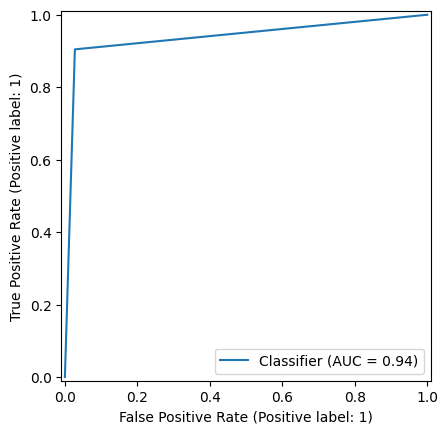

In [83]:
# ROC CURVE
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(pipeline_log_reg_GS_best,X,y,cv=skf,n_jobs=-1)
roc = RocCurveDisplay.from_predictions(y,y_pred)
plt.show()

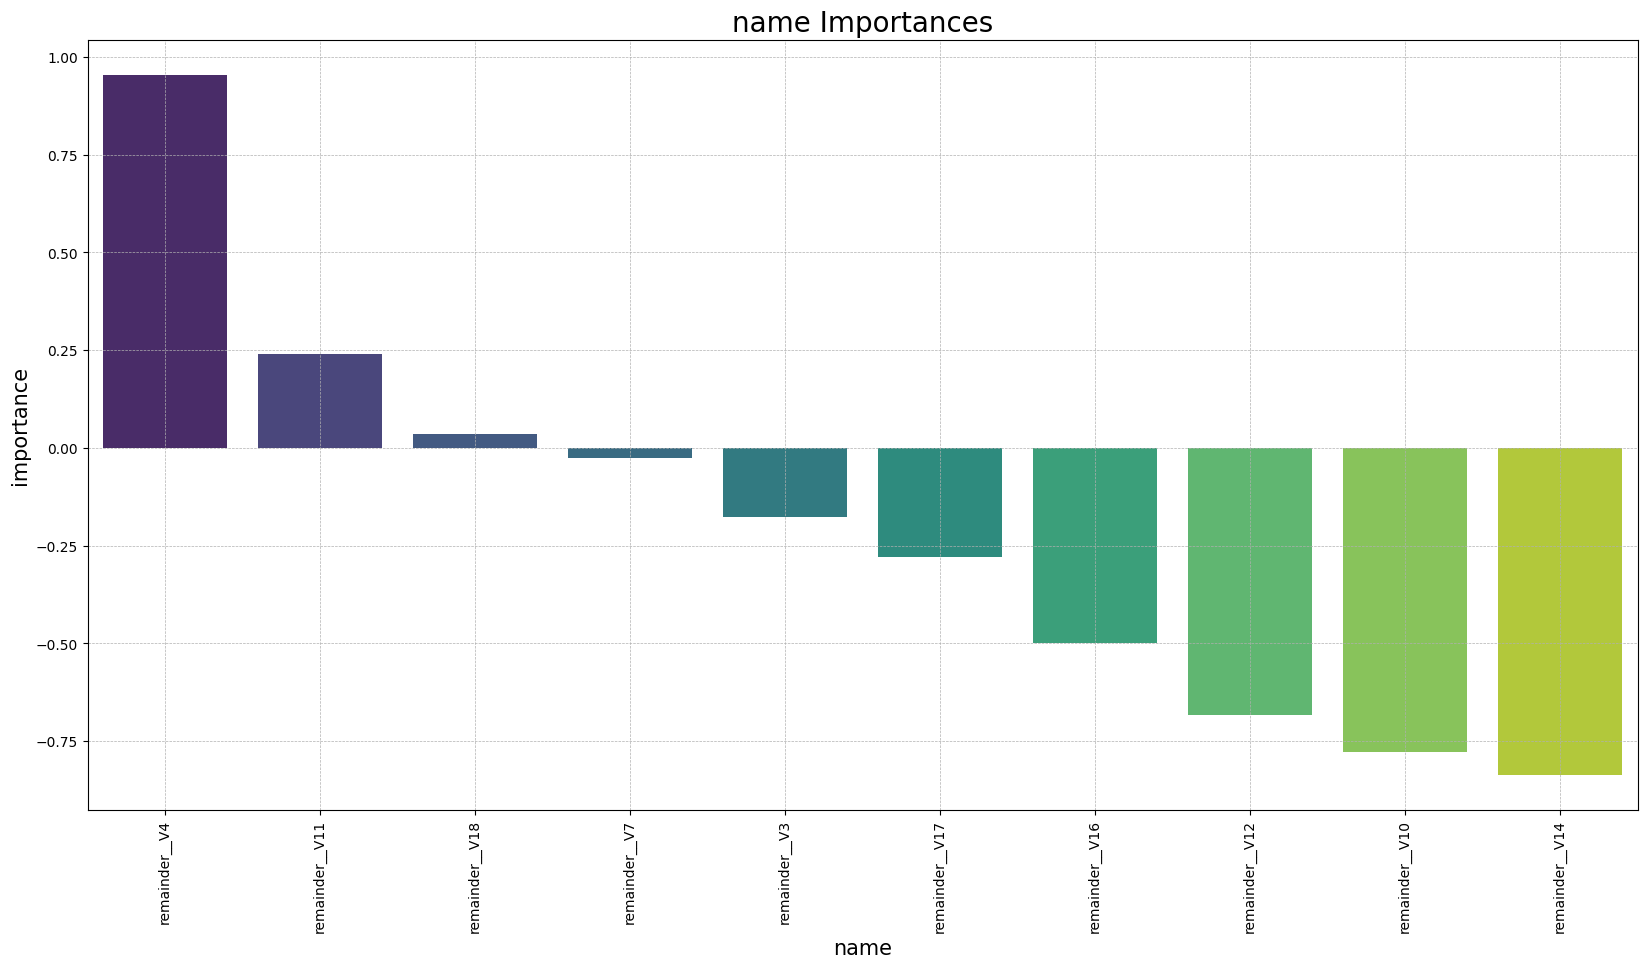

In [84]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=df_importace['name'], y=df_importace['importance'], palette='viridis', data=df_importace)
ax.tick_params(axis='x', rotation=90)
ax.set_title('name Importances', fontsize=20)
ax.set_xlabel('name', fontsize=15)
ax.set_ylabel('importance', fontsize=15)
ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()

# WHAT IF WE REMOVE ALL OF THE OUTLIERS IN THE DATABASE? WE`LL hAVE BETTER RESULTS? LET`S FIND OUT

# I will do this step in the next jupyter notebook